In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib
import numpy as np
from google.colab import files

uploaded = files.upload()
file_path = next(iter(uploaded))
dataset = pd.read_csv(file_path)

if dataset.empty:
    raise ValueError("The dataset is empty. Please check the uploaded file.")

data_preprocessed = dataset.drop(columns=['Tourist_ID', 'total_cost_USD'])

label_encoders = {}
for column in ['Come_From', 'Gender', 'Travel_Purpose', 'Preferred_Destination', 'travel_with', 'Traveler_Type']:
    le = LabelEncoder()
    data_preprocessed[column] = le.fit_transform(data_preprocessed[column])
    label_encoders[column] = le

scaler = StandardScaler()
data_preprocessed[['Age', 'Travel_Frequency_per_Year']] = scaler.fit_transform(
    data_preprocessed[['Age', 'Travel_Frequency_per_Year']]
)

X = data_preprocessed.drop(columns=['Traveler_Type'])
y = data_preprocessed['Traveler_Type']

data_balanced = pd.concat([X, y], axis=1)
high_class = data_balanced[data_balanced['Traveler_Type'] == 0]
low_class = data_balanced[data_balanced['Traveler_Type'] == 1]
medium_class = data_balanced[data_balanced['Traveler_Type'] == 2]

max_class_size = max(len(high_class), len(low_class), len(medium_class))
high_class_balanced = resample(high_class, replace=True, n_samples=max_class_size, random_state=42)
low_class_balanced = resample(low_class, replace=True, n_samples=max_class_size, random_state=42)
medium_class_balanced = resample(medium_class, replace=True, n_samples=max_class_size, random_state=42)

data_balanced = pd.concat([high_class_balanced, low_class_balanced, medium_class_balanced])

X_balanced = data_balanced.drop(columns=['Traveler_Type'])
y_balanced = data_balanced['Traveler_Type']

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42
)

print("\n=== Baseline Model ===")
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_balanced, y_train_balanced)
y_pred_baseline = rf_baseline.predict(X_test_balanced)
print("Baseline Accuracy:", accuracy_score(y_test_balanced, y_pred_baseline))
print("\nClassification Report:\n", classification_report(y_test_balanced, y_pred_baseline))

print("\n=== Final Tuned Model ===")
final_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

final_rf_model.fit(X_train_balanced, y_train_balanced)

cv_scores = cross_val_score(final_rf_model, X_balanced, y_balanced, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

cost_matrix = np.array([
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1]
])

y_pred_proba = final_rf_model.predict_proba(X_test_balanced)

cost_adjusted_scores = np.dot(y_pred_proba, cost_matrix.T)

y_pred_cost_adjusted = np.argmax(cost_adjusted_scores, axis=1)

final_accuracy_cost_adjusted = accuracy_score(y_test_balanced, y_pred_cost_adjusted)
final_classification_report_cost_adjusted = classification_report(
    y_test_balanced, y_pred_cost_adjusted, target_names=label_encoders['Traveler_Type'].classes_
)
confusion_mat_cost_adjusted = confusion_matrix(y_test_balanced, y_pred_cost_adjusted)

print("\n=== Cost-Adjusted Predictions ===")
print("Cost-Adjusted Accuracy:", final_accuracy_cost_adjusted)
print("\nCost-Adjusted Classification Report:\n", final_classification_report_cost_adjusted)
print("\nCost-Adjusted Confusion Matrix:\n", confusion_mat_cost_adjusted)

joblib.dump(final_rf_model, 'final_random_forest_model.pkl')
print("Final Random Forest Model saved as 'final_random_forest_model.pkl'.")

predictions = pd.DataFrame({'Actual': y_test_balanced, 'Predicted': y_pred_cost_adjusted})
predictions.to_csv('final_predictions.csv', index=False)
print("Predictions saved to 'final_predictions.csv'.")


Saving Tourism dataset.csv to Tourism dataset.csv

=== Baseline Model ===
Baseline Accuracy: 0.7465051258154707

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       386
           1       0.78      0.79      0.79       328
           2       0.70      0.70      0.70       359

    accuracy                           0.75      1073
   macro avg       0.75      0.75      0.75      1073
weighted avg       0.75      0.75      0.75      1073


=== Final Tuned Model ===
Cross-Validation Scores: [0.74184529 0.75768872 0.75582479 0.75116496 0.77238806]
Mean Cross-Validation Accuracy: 0.7557823649691895

=== Cost-Adjusted Predictions ===
Cost-Adjusted Accuracy: 0.750232991612302

Cost-Adjusted Classification Report:
               precision    recall  f1-score   support

        High       0.75      0.80      0.77       386
         Low       0.79      0.77      0.78       328
      Medium       0.71      0.68      0.69

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

y_val_pred = final_rf_model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {validation_accuracy:.2f}")

y_train_pred = final_rf_model.predict(X_train_balanced)
training_accuracy = accuracy_score(y_train_balanced, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

y_test_pred = final_rf_model.predict(X_test_balanced)
testing_accuracy = accuracy_score(y_test_balanced, y_test_pred)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

Validation Accuracy: 0.90
Training Accuracy: 0.94
Testing Accuracy: 0.75


In [ ]:
import pandas as pd
import joblib

final_rf_model = joblib.load('final_random_forest_model.pkl')

new_traveler = pd.DataFrame([{
    "Come_From": "Germany",
    "Gender": "Female",
    "Travel_Purpose": "Medical",
    "Preferred_Destination": "Beach",
    "travel_with": "With Family",
    "Age": 60,
    "Travel_Frequency_per_Year": 10
}])

training_features = list(X_train_balanced.columns)
new_traveler = new_traveler.reindex(columns=training_features, fill_value=0)

for column in ['Come_From', 'Gender', 'Travel_Purpose', 'Preferred_Destination', 'travel_with']:
    new_traveler[column] = label_encoders[column].transform(new_traveler[column])

new_traveler[['Age', 'Travel_Frequency_per_Year']] = scaler.transform(
    new_traveler[['Age', 'Travel_Frequency_per_Year']]
)

traveler_prediction = final_rf_model.predict(new_traveler)
traveler_type = label_encoders['Traveler_Type'].inverse_transform(traveler_prediction)

print("Predicted Traveler Type:", traveler_type[0])


Predicted Traveler Type: High


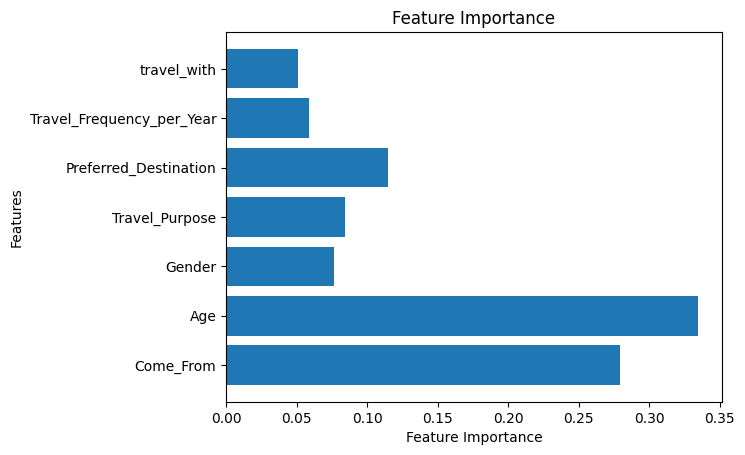

In [ ]:
import matplotlib.pyplot as plt

feature_importances = final_rf_model.feature_importances_
plt.barh(training_features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()


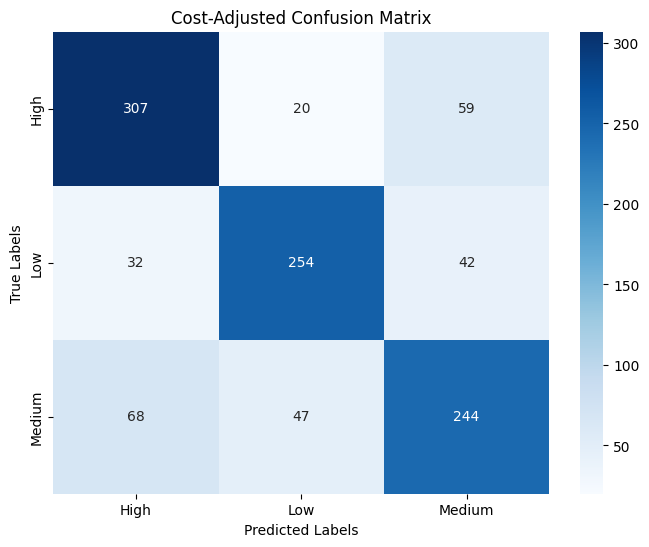

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_cost_adjusted, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoders['Traveler_Type'].classes_,
            yticklabels=label_encoders['Traveler_Type'].classes_)

plt.title('Cost-Adjusted Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
